## El modelo

**Hipóteisis:** los actores de una familia migran a otras y su estilo discursivo es detectable, logrando así atribuciones en base a análisis discursivo.

Hay que construir un espacio semántico común a partir del corpus merged de Conti, que permita proyectar conversaciones de otras familias (p. ej. BlackBasta) y medir proximidad discursiva entre actores de distintas organizaciones.

El build genera embeddings (actor-level) desde un corpus actor-céntrico JSONL y (en otro paso) realiza fine-tuning auto-supervisado contrastivo para capturar estilo
  --model DeepPavlov/rubert-base-cased   (o equivalente RuBERT/RuRoBERTa)

Entrenamiento:
  MultipleNegativesRankingLoss (in-batch negatives)
  Positivos: pares de chunks del mismo actor
  Negativos: chunks de otros actores en el batch

Evaluación:
  Recall@K (por defecto K=10) en un retrieval de chunks:
    Query chunk -> top-k similares -> acierto si aparece otro chunk del mismo actor


No todos los actores tienen suficiente producción lingüística para inferir estilo; el modelo se entrena solo sobre aquellos con masa discursiva suficiente. 

El texto de cada actor se divide en chunks estilísticos (ventanas de mensajes). Solo se conserva si tiene ≥ 3 chunks menos no peritiría el entreno contrastivo (≥2 chunks para formar un positivo (mismo actor) ≥1 chunk adicional para que el actor sea útil en evaluación sin trivialidad.)

El v2 endurece redacción (para minimizar topic leakage) y añadir deduplicación (para evitar que el Recall@10 se infle por frases repetidas/plantillas)


### Test y entrenos
```
(lux) drjekyll@mrhyde:~/Documentos/dark/dark-speech$ python3 -u ransomtales/src/embed/build_embeddings.py \
  --corpus ransomtales/data/processed/conti_actor_corpus_merged_rocket_plus_jabber.jsonl \
  --outdir models/embeddings_rubert \
  --model DeepPavlov/rubert-base-cased \
  --recall-k 10
```
 
 Se obtiene:
```json
  {
  "model": "DeepPavlov/rubert-base-cased",
  "device": "cuda",
  "n_actors_total": 252,
  "n_actors_train": 215,
  "n_actors_eval": 37,
  "chunk_max_chars": 600,
  "min_chunks_per_actor": 3,
  "recall_k": 10,
  "recall_at_k_before": 0.8545542401546268
  }
  ```
 Creo un v2 que busca una redacción más estricta y limpio el corpus de url etc para evitar duplicidades
 
```
(lux) drjekyll@mrhyde:~/Documentos/dark/dark-speech$ python3 -u ransomtales/src/embed/build_embeddings_v2.py \
  --corpus ransomtales/data/processed/conti_actor_corpus_merged_rocket_plus_jabber.jsonl \
  --outdir models/embeddings_rubert_strict \
  --model DeepPavlov/rubert-base-cased \
  --recall-k 10 
```

   Se obtiene:
   
```json

{
  "model": "DeepPavlov/rubert-base-cased",
  "n_actors_total": 242,
  "n_actors_train": 206,
  "n_actors_eval": 36,
  "chunk_max_chars": 600,
  "min_chunks_per_actor": 3,
  "recall_k": 10,
  "recall_at_k_before": 0.8752107925801011
}
```

  

### Fine tunning
```
(lux) drjekyll@mrhyde:~/Documentos/dark/dark-speech$ python3 -u ransomtales/src/embed/build_embeddings_v2.py \
  --corpus ransomtales/data/processed/conti_actor_corpus_merged_rocket_plus_jabber.jsonl \
  --outdir models/embeddings_rubert_strict_ft1 \
  --model DeepPavlov/rubert-base-cased \
  --fine-tune \
  --epochs 1 \
  --batch-size 8 \
  --lr 2e-5 \
  --chunk-max-chars 600 \
  --min-chunks-per-actor 3 \
  --max-pairs-per-actor 50 \
  --eval-split 0.15 \
  --recall-k 10
  ```

Y SE OBTIENE:

```json
{
  "n_actors_total": 242,
  "recall_at_k_before": 0.8752107925801011,
  "recall_at_k_after": 0.9283305227655987
}
```



## Gráficas de post entreno
El modelo no separa de forma binaria, pero la similitud coseno es informativa para distinguir misma pluma vs actores distintos. Aunque existe solapamiento (normal en lenguaje natural) la separación estadística explica alto Recall@10  y justifica el uso del embedding para búsquedas de proximidad entre actores.



In [4]:
import json
import re
from pathlib import Path


corpus_path = Path.home() / "Documentos" / "dark" / "dark-speech" / "ransomtales" / "data" / "processed" / "conti_actor_corpus_merged_rocket_plus_jabber.jsonl"

_RE_URL = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
_RE_ONION = re.compile(r"\b[a-z2-7]{16,56}\.onion\b", re.IGNORECASE)
_RE_JID = re.compile(r"\b[a-z0-9._\-]+@[a-z0-9.\-]+\.onion\b", re.IGNORECASE)
_RE_EMAIL = re.compile(r"\b[a-z0-9._%+\-]+@[a-z0-9.\-]+\.[a-z]{2,}\b", re.IGNORECASE)
_RE_IPV4 = re.compile(r"\b(?:(?:25[0-5]|2[0-4]\d|[01]?\d\d?)\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d?)\b")
_RE_IPV4_PORT = re.compile(r"\b(?:(?:25[0-5]|2[0-4]\d|[01]?\d\d?)\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d?):\d{1,5}\b")
_RE_HASH = re.compile(r"\b[a-f0-9]{32,128}\b", re.IGNORECASE)
_RE_HEXLIKE = re.compile(r"\b0x[a-f0-9]+\b", re.IGNORECASE)
_RE_BTC = re.compile(r"\b[13][a-km-zA-HJ-NP-Z1-9]{25,34}\b")
_RE_BASE64ISH = re.compile(r"\b[A-Za-z0-9+/]{80,}={0,2}\b")
_RE_WIN_PATH = re.compile(r"\b[A-Za-z]:\\(?:[^\\\s]+\\)+[^\\\s]+\b")
_RE_UNIX_PATH = re.compile(r"(?:/[^/\s]+)+")
_RE_NUM_LONG = re.compile(r"\b\d{6,}\b")

def redact(text: str) -> str:
    t = text.replace("\u00a0", " ")
    t = re.sub(r"\s+", " ", t).strip()
    t = _RE_URL.sub("<URL>", t)
    t = _RE_JID.sub("<JID_ONION>", t)
    t = _RE_ONION.sub("<ONION>", t)
    t = _RE_IPV4_PORT.sub("<IP_PORT>", t)
    t = _RE_IPV4.sub("<IP>", t)
    t = _RE_EMAIL.sub("<EMAIL>", t)
    t = _RE_WIN_PATH.sub("<PATH>", t)
    t = _RE_UNIX_PATH.sub("<PATH>", t)
    t = _RE_HASH.sub("<HASH>", t)
    t = _RE_HEXLIKE.sub("<HEX>", t)
    t = _RE_BTC.sub("<BTC_ADDR>", t)
    t = _RE_BASE64ISH.sub("<BLOB>", t)
    t = _RE_NUM_LONG.sub("<NUM>", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def make_chunks_from_text(text: str, chunk_max_chars: int = 600) -> list[str]:
    # split a líneas / mensajes
    lines = [ln.strip() for ln in text.split("\n") if ln.strip()]
    seen_lines = set()
    cleaned = []

    for ln in lines:
        if len(ln) < 2:
            continue
        ln = redact(ln)
        if len(ln) < 3:  # filtra "+" etc.
            continue
        if ln in seen_lines:
            continue
        seen_lines.add(ln)
        cleaned.append(ln)

    if not cleaned:
        return []

    # chunking
    chunks = []
    buf = []
    cur = 0
    for ln in cleaned:
        ln_len = len(ln)
        if cur + ln_len + 1 > chunk_max_chars and buf:
            chunks.append(" ".join(buf))
            buf = [ln]
            cur = ln_len
        else:
            buf.append(ln)
            cur += ln_len + 1
    if buf:
        chunks.append(" ".join(buf))

    # dedupe chunks
    seen_chunks = set()
    uniq = []
    for ch in chunks:
        ch = re.sub(r"\s+", " ", ch).strip()
        if len(ch) < 20:
            continue
        if ch in seen_chunks:
            continue
        seen_chunks.add(ch)
        uniq.append(ch)

    return uniq

# construcción actor_chunks
actor_chunks = {}
min_chunks_per_actor = 3
chunk_max_chars = 600

with corpus_path.open("r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        actor = obj["actor"]
        text = obj.get("text", "") or ""
        chunks = make_chunks_from_text(text, chunk_max_chars=chunk_max_chars)
        if len(chunks) >= min_chunks_per_actor:
            actor_chunks[actor] = chunks

len(actor_chunks), list(actor_chunks.items())[0][0], len(list(actor_chunks.items())[0][1])



(242, 'user8', 1198)

The tokenizer you are loading from '/home/drjekyll/Documentos/dark/dark-speech/models/embeddings_rubert_final/model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


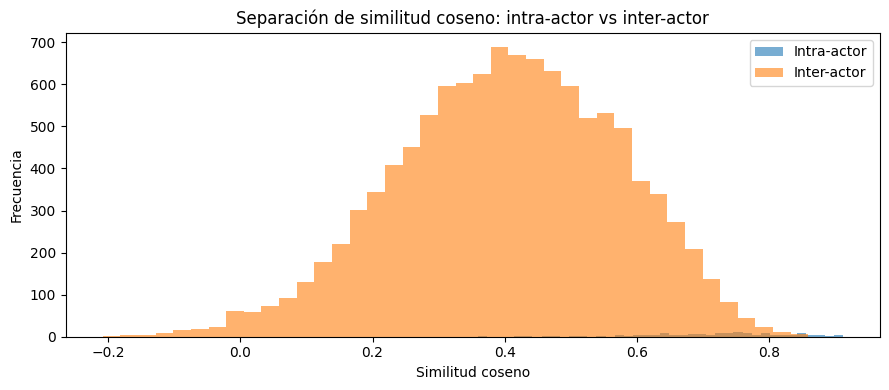

Ejemplos: intra_mean= 0.7196670671304067  inter_mean= 0.4041357110570398


In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer(str(Path.home() / "Documentos" / "dark" / "dark-speech" / "models" / "embeddings_rubert_final" / "model"))

# muestreo razonable
sample_actors = list(actor_chunks.keys())
random.shuffle(sample_actors)
sample_actors = sample_actors[:50]

texts, labels = [], []
for a in sample_actors:
    for ch in actor_chunks[a][:3]:
        texts.append(ch)
        labels.append(a)

emb = model.encode(texts, normalize_embeddings=True)

pos_sims, neg_sims = [], []
for i in range(len(texts)):
    for j in range(i+1, len(texts)):
        sim = util.cos_sim(emb[i], emb[j]).item()
        if labels[i] == labels[j]:
            pos_sims.append(sim)
        else:
            neg_sims.append(sim)

plt.figure(figsize=(9,4))
plt.hist(pos_sims, bins=40, alpha=0.6, label="Intra-actor")
plt.hist(neg_sims, bins=40, alpha=0.6, label="Inter-actor")
plt.title("Separación de similitud coseno: intra-actor vs inter-actor")
plt.xlabel("Similitud coseno")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

print("Ejemplos: intra_mean=", np.mean(pos_sims), " inter_mean=", np.mean(neg_sims))


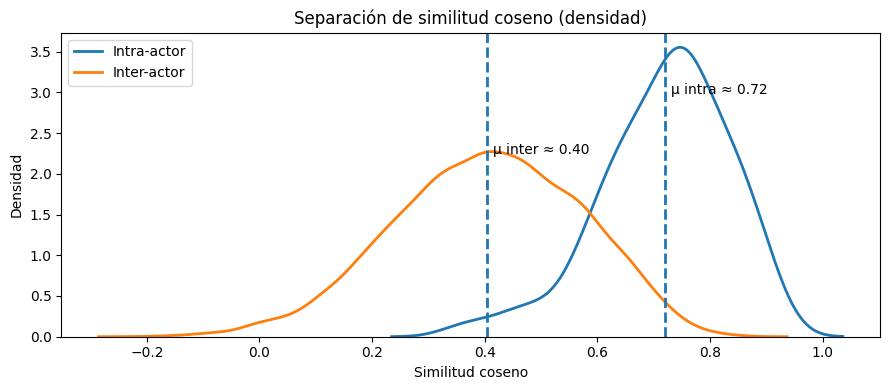

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,4))

sns.kdeplot(pos_sims, label="Intra-actor", linewidth=2)
sns.kdeplot(neg_sims, label="Inter-actor", linewidth=2)

plt.axvline(np.mean(pos_sims), linestyle="--", linewidth=2)
plt.axvline(np.mean(neg_sims), linestyle="--", linewidth=2)

plt.text(np.mean(pos_sims)+0.01, plt.ylim()[1]*0.8,
         f"μ intra ≈ {np.mean(pos_sims):.2f}")
plt.text(np.mean(neg_sims)+0.01, plt.ylim()[1]*0.6,
         f"μ inter ≈ {np.mean(neg_sims):.2f}")

plt.title("Separación de similitud coseno (densidad)")
plt.xlabel("Similitud coseno")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


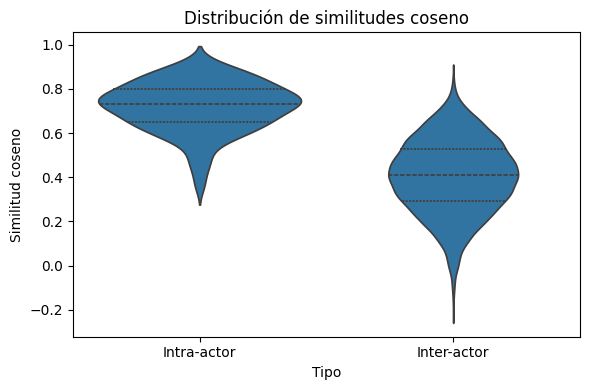

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Similitud coseno": pos_sims + neg_sims,
    "Tipo": ["Intra-actor"] * len(pos_sims) + ["Inter-actor"] * len(neg_sims)
})

plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="Tipo", y="Similitud coseno", inner="quartile")
plt.title("Distribución de similitudes coseno")
plt.tight_layout()
plt.show()
